# Goals for this model

Given a dataset of movie features, try to predict a movie's IMDB score before it is released.

# Todo List

- [X] apply GridSearchCV to each model
- [X] roll in the preprocessing steps to 
  - [X] cleanse data (e.g. parse country and release date, append release year to name)
  - [X] split data into new columns (release date to release year, month, day, etc.)
- [X] collect each models' regression statistics into a dataframe for comparing models
- [X] test this script on predicting budget rather than score. do the results match moy's? is it easy to change the outcome variable?
- [X] make normalization work for regression models (now that we have models other than linear regression we need it)

# About the Data

### Movie Industry | Four decades of movies

[via Daniel Grijalva on Kaggle](https://www.kaggle.com/danielgrijalvas/movies)

#### Context

Is the movie industry dying? is Netflix the new entertainment king? Those were the first questions that lead me to create a dataset
focused on movie revenue and analyze it over the last decades. But, why stop there? There are more factors that intervene in this
kind of thing, like actors, genres, user ratings and more. And now, anyone with experience (you) can ask specific questions about the
movie industry, and get answers.

#### Content

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

- budget: the budget of a movie. Some movies don't have this, so it appears as 0
- company: the production company
- country: country of origin
- director: the director
- genre: main genre of the movie.
- gross: revenue of the movie
- name: name of the movie
- rating: rating of the movie (R, PG, etc.)
- released: release date (YYYY-MM-DD)
- runtime: duration of the movie
- score: IMDb user rating
- votes: number of user votes
- star: main actor/actress
- writer: writer of the movie
- year: year of release

### Acknowledgements

This data was scraped from IMDb.

# Imports

In [5]:
from pathlib import Path

import pandas as pd
import numpy as np
from patsy import dmatrices # https://pypi.org/project/patsy/

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR,SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor #Multi-layer Perceptron (not very powerful)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import explained_variance_score as explained_var, mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Collection of utility functions used in the book
# Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python (First Edition)
# Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel (c) 2019 John Wiley & Sons, Inc.
#
# Published under MIT License
# https://pypi.org/project/dmba/
# https://www.dataminingbook.com/book/python-edition.
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import backward_elimination, forward_selection, stepwise_selection, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score


# Base Inputs

In [6]:
# input definitions
fPath = '../../_data/_processed/'
fName = 'processed_for_viz.csv' # preprocessing already done
fName = 'BudgetImputed.csv' # output from Moy's processing script
#fPath = '../../_data/_raw/'
#fName = 'movies.csv' # original raw data
file = (fPath + fName) # preprocessing already done

outcome_var_name = 'score'
continuous = True


# Read Data

In [7]:
# get data
df = pd.read_csv(fPath + fName)

# Basic Data Exploration

In [8]:
print('First few rows')
df.head(10)

First few rows


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0
6,The Blues Brothers,R,Action,1980,"June 20, 1980 (United States)",7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,115229890.0,Universal Pictures,133.0
7,Raging Bull,R,Biography,1980,"December 19, 1980 (United States)",8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,18000000.0,23402427.0,Chartoff-Winkler Productions,129.0
8,Superman II,PG,Action,1980,"June 19, 1981 (United States)",6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000.0,108185706.0,Dovemead Films,127.0
9,The Long Riders,R,Biography,1980,"May 16, 1980 (United States)",7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,10000000.0,15795189.0,United Artists,100.0


In [9]:
df.columns

Index(['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'budget', 'gross', 'company',
       'runtime'],
      dtype='object')

## Column Preprocessing

In [10]:
def remove_column_name_special_chars(df):
    print('Replace special characters (spaces, etc) from column names')
    import re
    df.columns = [re.sub('[ |^&+\-%*/=!>]', '_', c) for c in df.columns ]
    return df

df = remove_column_name_special_chars(df)
df.columns

Replace special characters (spaces, etc) from column names


Index(['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'budget', 'gross', 'company',
       'runtime'],
      dtype='object')

In [11]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


In [12]:
print('Basic Descriptive Statistics')
df.describe()

Basic Descriptive Statistics


,year,score,votes,budget,gross,runtime
count,7404.000000,7404.000000,7.404000e+03,7.404000e+03,7.404000e+03,7404.000000
mean,2000.636683,6.396569,9.082277e+04,3.018414e+07,7.902401e+07,107.438682
std,11.021332,0.962366,1.654105e+05,3.734078e+07,1.662593e+08,18.517094
min,1980.000000,1.900000,1.050000e+02,6.000000e+03,3.090000e+02,63.000000
25%,1991.000000,5.800000,1.000000e+04,9.000000e+06,4.637415e+06,95.000000
50%,2001.000000,6.500000,3.400000e+04,1.700000e+07,2.043974e+07,104.000000
75%,2010.000000,7.100000,9.600000e+04,3.500000e+07,7.647596e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [13]:
numeric_features = df.select_dtypes(['number']).columns
non_numeric_features = df.drop(columns=numeric_features).columns
print(numeric_features)
print(non_numeric_features)

Index(['year', 'score', 'votes', 'budget', 'gross', 'runtime'], dtype='object')
Index(['name', 'rating', 'genre', 'released', 'director', 'writer', 'star',
       'country', 'company'],
      dtype='object')


feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross - 0.00%
company - 0.00%
runtime - 0.00%


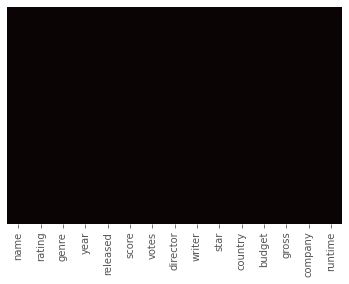

In [14]:
def list_missing(df):
    print('feature - % missing')
    print('-'*50)
    for col in df.columns:
        percent_missing = np.mean(df[col].isnull())
        print(f'{col} - {percent_missing*100:.2f}%')
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='mako')
    plt.show()

list_missing(df)

# Preprocessing

In [15]:
df_no_preprocessing = df.copy() # save off a copy of the data prior to preprocessing

### Handle Initial Data Cleaning

In [16]:
# rename gross to avoid confusion
df.rename(columns = {'gross' : 'gross_revenue'}, inplace=True)

In [17]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


In [18]:
# split released into columns for month, day, year

# split released
df[['release_month', 'release_day', 'release_year', 'other']] = df['released'].str.split(' ', n=3, expand=True)

df['release_day'] = df['release_day'].str.replace(',','') # loose the , in day and make it at int
# some of the values in 'released' are not full dates... drop those
months = ['June', 'July', 'May', 'December', 'October', 'September',
    'February', 'April', 'August', 'March', 'November', 'January']

df = df[df['release_month'].isin(months)]
df = df[df['release_day'].astype(int) <= 31]

df['release_day'] = df['release_day'].astype(int)
df['release_year'] = df['release_year'].astype(int)



In [19]:
# add other columns that are release date related

# rebuild a valid 'release date' column
from time import strptime
df['release_month_num'] = [strptime(str(x), '%B').tm_mon for x in df['release_month']]
df['release_date'] = pd.to_datetime(df['release_month_num'].astype(str) +'-'+ df['release_day'].astype(str) +'-'+ df['release_year'].astype(str))

# add a 'release quater' column
df['release_quarter'] = (df['release_month_num'].astype(int)-1)//3 + 1

# add 'release day of week' column
df['release_day_of_week'] = df['release_date'].dt.day_name()

# show that all release date related attributes are valid
print(df['release_day_of_week'].unique())
print(df['release_day'].unique())
print(df['release_year'].unique())

# show that quarter values are correctly mapped to months
print(df.groupby(['release_month_num', 'release_month','release_quarter']).size().reset_index().rename(columns={0:'count'}))


['Friday' 'Wednesday' 'Tuesday' 'Thursday' 'Saturday' 'Sunday' 'Monday']
[13  2 20 25  9 19 16 17 26 12  3  8 15 24  1 10 30 27 11 28 21  6 18 31
 14 22  4  5 23 29  7]
[1980 1981 1984 1983 1982 1987 1985 1986 1990 1988 1992 1989 1991 1999
 1994 1993 1995 2001 1996 2000 1997 1998 2002 2003 2004 2014 2005 2006
 2007 2008 2010 2009 2013 2011 2016 2015 2012 2017 2018 2019 2020]
    release_month_num release_month  release_quarter  count
0                   1       January                1    574
1                   2      February                1    580
2                   3         March                1    660
3                   4         April                2    621
4                   5           May                2    551
5                   6          June                2    544
6                   7          July                3    566
7                   8        August                3    713
8                   9     September                3    631
9                  10 

In [20]:
# Add a title field that has the release year appended to name

df['title'] = df['name'] + ' (' + df['release_year'].astype(str) + ')'

In [21]:
# Add Gross Profit etc
df['gross_profit'] = df['gross_revenue'] - df['budget']
df['profit_margin'] = df['gross_profit'] / df['budget']
df['profit_multiple'] = df['gross_revenue'] / df['budget']

In [22]:
# inspect final cleansed data
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


### Handle Missing Values
TODO: Currently missing values are handled in Moy's preprocessing script and we're using output as this script's input

### Imput the average budget for the same genre and release year


Before Imput
feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


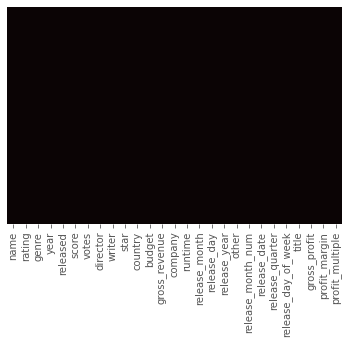

After Imput
feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


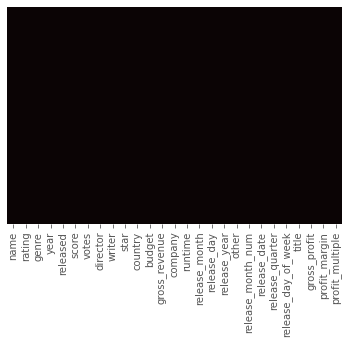

In [23]:
# only has an impact if na's still exist
print('Before Imput')
list_missing(df)
df['budget'].fillna(df.groupby(['genre','release_year'])['budget'].transform('mean'), inplace=True)
df['budget'].fillna(df.groupby(['release_year'])['budget'].transform('mean'), inplace=True)
df['budget'].fillna(df.groupby(['genre'])['budget'].transform('mean'), inplace=True)
print('After Imput')
list_missing(df) 

### Last resort is to imput the overall budget mean or median

#### Is budget normally distributed?

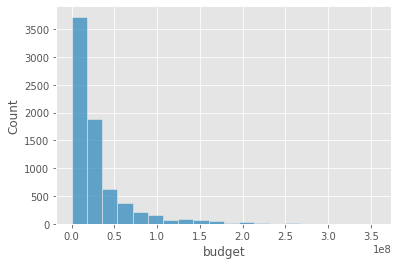

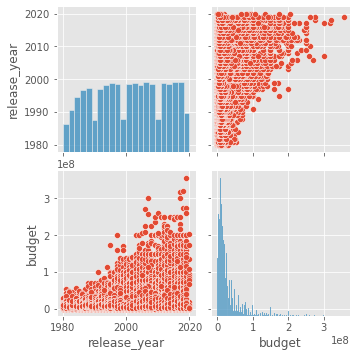

In [24]:
df_missing_budget = df[df['budget'].isna()]
df_have_budget = df[df['budget'].notna()]
sns.histplot(df_have_budget, x='budget', bins=20)

cols_to_plot = ['release_year', 'budget', 'genre']
sns.pairplot(df_have_budget[cols_to_plot])
plt.show()

No budgets are not normally distributed therefore we should not imput the overall mean.

It also seems clear that budgets rise over time. Maybe imputing the average budget for the release year will work.

In [25]:
df['budget'].fillna(df_have_budget['budget'].median(), inplace=True) # only has an impact if na's still exist

#### Drop any missing data rows that might still remain

feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


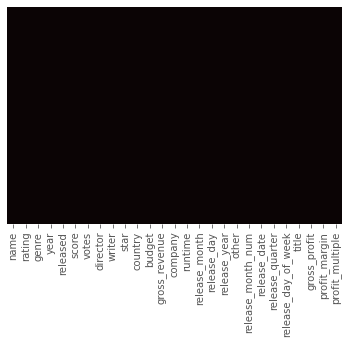

In [26]:
# if we couldn't imput missing budget values then drop the column
if np.mean(df['budget'].isnull()) > 0:
    df = df.drop(columns=['budget'])

# Since there is a small % of missing data for the remaining columns, we will drop all rows with any null values
df = df.dropna(how='any',axis=0)

#double check and confirm there is NO null value in the data
list_missing(df)

### Handle Final Data Cleansing


In [27]:
# Drop unwanted columns
try:
    df.drop(columns=['other', 'released', 'year'], inplace=True) #drop columns we don't need anymore
except:
    print('Nothing dropped. Columns referenced are not in the data. Have you already run this?')


In [28]:
#Drop bad data
df = df.loc[df['budget'] >= 0] #budget can't be negative drop anything with a negative budget


In [29]:
#Drop duplicates
df.drop_duplicates()

,name,rating,genre,score,votes,director,writer,star,country,budget,...,release_day,release_year,release_month_num,release_date,release_quarter,release_day_of_week,title,gross_profit,profit_margin,profit_multiple
0,The Shining,R,Drama,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,1.900000e+07,...,13,1980,6,1980-06-13,2,Friday,The Shining (1980),2.799877e+07,1.473620,2.473620
1,The Blue Lagoon,R,Adventure,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4.500000e+06,...,2,1980,7,1980-07-02,3,Wednesday,The Blue Lagoon (1980),5.435311e+07,12.078468,13.078468
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,1.800000e+07,...,20,1980,6,1980-06-20,2,Friday,Star Wars: Episode V - The Empire Strikes Back...,5.203751e+08,28.909726,29.909726
3,Airplane!,PG,Comedy,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3.500000e+06,...,2,1980,7,1980-07-02,3,Wednesday,Airplane! (1980),7.995354e+07,22.843868,23.843868
4,Caddyshack,R,Comedy,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6.000000e+06,...,25,1980,7,1980-07-25,3,Friday,Caddyshack (1980),3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,Wonder Woman 1984,PG-13,Action,5.4,217000.0,Patty Jenkins,Patty Jenkins,Gal Gadot,United States,1.075850e+08,...,25,2020,12,2020-12-25,4,Friday,Wonder Woman 1984 (2020),5.894903e+07,0.547930,1.547930
7400,Onward,PG,Animation,7.4,120000.0,Dan Scanlon,Dan Scanlon,Tom Holland,United States,6.773000e+07,...,6,2020,3,2020-03-06,1,Friday,Onward (2020),7.422061e+07,1.095831,2.095831
7401,The Quarry,R,Crime,5.4,2400.0,Scott Teems,Scott Teems,Shea Whigham,United States,4.435112e+06,...,17,2020,4,2020-04-17,2,Friday,The Quarry (2020),-4.431451e+06,-0.999175,0.000825
7402,Tulsa,PG-13,Comedy,5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,United States,7.236143e+06,...,3,2020,6,2020-06-03,2,Wednesday,Tulsa (2020),-6.822765e+06,-0.942873,0.057127


In [30]:
# inspect data one last time
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson
country,United Kingdom
budget,19000000.0


In [31]:
df_preprocessed = df.copy() # save off a copy of the data after preprocessing (this should be the data to be used for data viz)
#df_preprocessed.to_csv('preprocessing_done.csv')

# Feature Selection

### Drop very unique non-numeric columns

Categorical data with many unique values cause issues with converted to dummy variables

In [32]:
numeric_features = df.select_dtypes(['number']).columns
non_numeric_features = df.drop(columns=numeric_features).columns
print(numeric_features)
print(non_numeric_features)

Index(['score', 'votes', 'budget', 'gross_revenue', 'runtime', 'release_day',
       'release_year', 'release_month_num', 'release_quarter', 'gross_profit',
       'profit_margin', 'profit_multiple'],
      dtype='object')
Index(['name', 'rating', 'genre', 'director', 'writer', 'star', 'country',
       'company', 'release_month', 'release_date', 'release_day_of_week',
       'title'],
      dtype='object')


In [33]:
print('Unique Counts')
unique_counts = df.drop(columns=numeric_features).nunique(axis=0).sort_values()
very_unique_cols = unique_counts[unique_counts > 60].index

print(unique_counts)

Unique Counts
release_day_of_week       7
rating                    9
release_month            12
genre                    15
country                  57
company                2216
star                   2622
director               2802
release_date           2822
writer                 4330
name                   7213
title                  7356
dtype: int64


In [34]:
df.drop(columns=very_unique_cols, inplace=True)
df

,rating,genre,score,votes,country,budget,gross_revenue,runtime,release_month,release_day,release_year,release_month_num,release_quarter,release_day_of_week,gross_profit,profit_margin,profit_multiple
0,R,Drama,8.4,927000.0,United Kingdom,1.900000e+07,46998772.0,146.0,June,13,1980,6,2,Friday,2.799877e+07,1.473620,2.473620
1,R,Adventure,5.8,65000.0,United States,4.500000e+06,58853106.0,104.0,July,2,1980,7,3,Wednesday,5.435311e+07,12.078468,13.078468
2,PG,Action,8.7,1200000.0,United States,1.800000e+07,538375067.0,124.0,June,20,1980,6,2,Friday,5.203751e+08,28.909726,29.909726
3,PG,Comedy,7.7,221000.0,United States,3.500000e+06,83453539.0,88.0,July,2,1980,7,3,Wednesday,7.995354e+07,22.843868,23.843868
4,R,Comedy,7.3,108000.0,United States,6.000000e+06,39846344.0,98.0,July,25,1980,7,3,Friday,3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,217000.0,United States,1.075850e+08,166534027.0,151.0,December,25,2020,12,4,Friday,5.894903e+07,0.547930,1.547930
7400,PG,Animation,7.4,120000.0,United States,6.773000e+07,141950608.0,102.0,March,6,2020,3,1,Friday,7.422061e+07,1.095831,2.095831
7401,R,Crime,5.4,2400.0,United States,4.435112e+06,3661.0,98.0,April,17,2020,4,2,Friday,-4.431451e+06,-0.999175,0.000825
7402,PG-13,Comedy,5.0,294.0,United States,7.236143e+06,413378.0,120.0,June,3,2020,6,2,Wednesday,-6.822765e+06,-0.942873,0.057127


### Correlation

Rule of thumb for strength of correlation [via statology](https://www.statology.org/what-is-a-strong-correlation/)

|Absolute value of r | Strength of relationship|
|----|----|
|r < 0.25 | No relationship|
|0.25 < r < 0.5 | Weak relationship|
|0.5 < r < 0.75 | Moderate relationship|
|r > 0.75 | Strong relationship|

In [35]:
def correlation_analysis(df, method='pearson'):
    correlations = df.corr(method=method)
    
    # clustermap
    plt.figure(figsize=(14,12))
    sns.clustermap(correlations, cmap='mako_r', annot=True, vmin=0.25)
    plt.show()
    
    #pairplot
    #sns.pairplot(df, kind="reg", hue= outcome_var)

    # classify the correlations by rule of thumb
    corr_unpiv = correlations.melt(
        ignore_index=False, 
        var_name='var_2', 
        value_name='correlation').reset_index().rename(columns = {'index':'var_1'}).sort_values(by='correlation', ascending=False)
    corr_unpiv['correlation'] = abs(corr_unpiv['correlation'])
    corr_unpiv = corr_unpiv[corr_unpiv.var_1 != corr_unpiv.var_2] # don't want to show relationships with self
    corr_unpiv.drop_duplicates(subset='correlation', inplace=True) # drop rows the report the inverse duplicates <- not an optimal method

    strong = .75
    moderate = .50
    weak = .25
    corr_unpiv['relationship'] = 'Strong'
    corr_unpiv.loc[corr_unpiv['correlation'] < strong, 'relationship'] = 'Moderate'
    corr_unpiv.loc[corr_unpiv['correlation'] < moderate, 'relationship'] = 'Weak'
    corr_unpiv.loc[corr_unpiv['correlation'] < weak, 'relationship'] = 'None'

    strong = corr_unpiv[corr_unpiv['relationship'] == 'Strong']
    moderate = corr_unpiv[corr_unpiv['relationship'] == 'Moderate']
    weak = corr_unpiv[corr_unpiv['relationship'] == 'Weak']
    no_rel = corr_unpiv[corr_unpiv['relationship'] == 'None']
    print(strong)
    print('-'*75)
    print(moderate)
    print('-'*75)
    print(weak)
    print('-'*75)


<Figure size 1008x864 with 0 Axes>

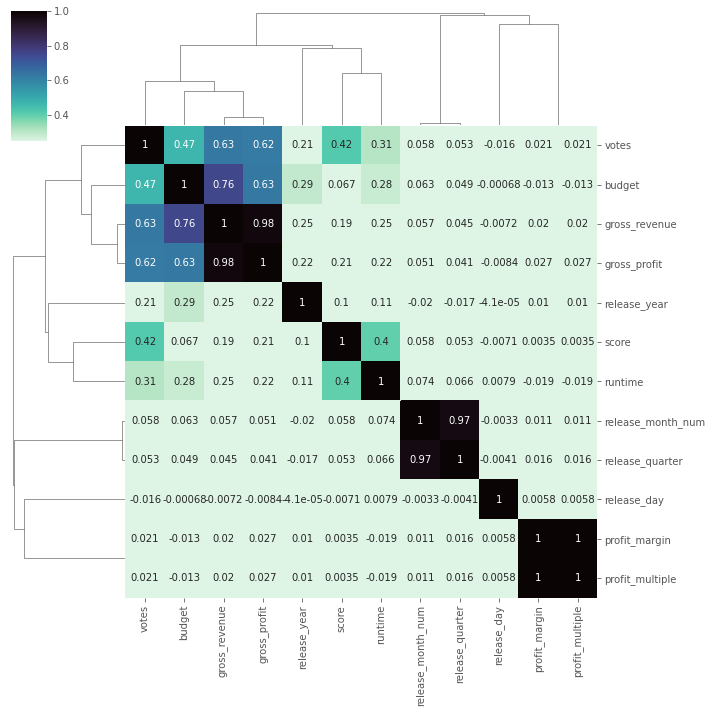

                 var_1            var_2  correlation relationship
142      profit_margin  profit_multiple     1.000000       Strong
45        gross_profit    gross_revenue     0.984707       Strong
103  release_month_num  release_quarter     0.971491       Strong
27       gross_revenue           budget     0.756213       Strong
---------------------------------------------------------------------------
            var_1   var_2  correlation relationship
33   gross_profit  budget     0.630653     Moderate
15  gross_revenue   votes     0.630471     Moderate
21   gross_profit   votes     0.622808     Moderate
---------------------------------------------------------------------------
           var_1          var_2  correlation relationship
14        budget          votes     0.469338         Weak
12         score          votes     0.417749         Weak
48         score        runtime     0.398534         Weak
16       runtime          votes     0.310627         Weak
74        budget   r

In [36]:
correlation_analysis(df)

<Figure size 1008x864 with 0 Axes>

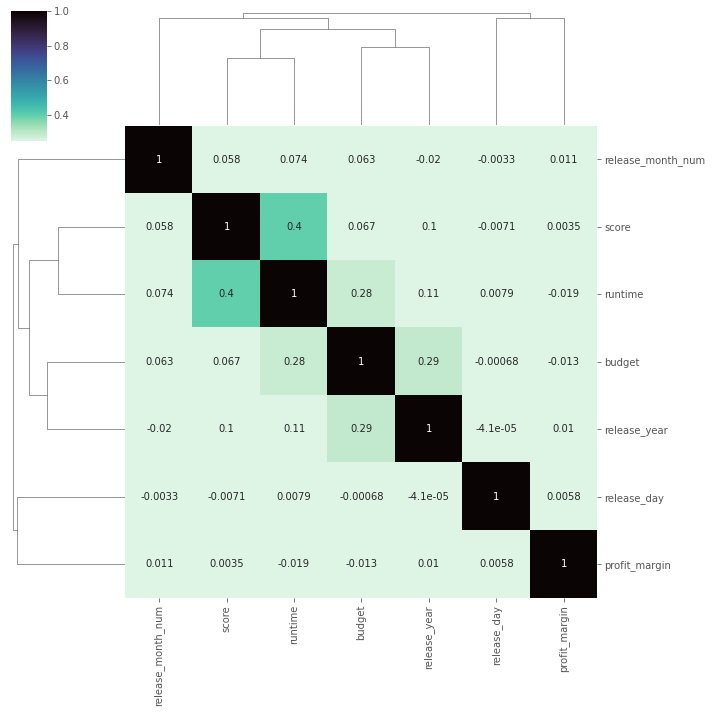

Empty DataFrame
Columns: [var_1, var_2, correlation, relationship]
Index: []
---------------------------------------------------------------------------
Empty DataFrame
Columns: [var_1, var_2, correlation, relationship]
Index: []
---------------------------------------------------------------------------
      var_1         var_2  correlation relationship
14    score       runtime     0.398534         Weak
29   budget  release_year     0.292740         Weak
9   runtime        budget     0.283661         Weak
---------------------------------------------------------------------------


In [37]:
dropped_for_correlation = ['profit_multiple', 'gross_profit', 'release_month', 'release_quarter', 'gross_revenue', 'votes']

correlation_analysis(df.drop(columns=dropped_for_correlation))

In [38]:
df.drop(columns=dropped_for_correlation, inplace=True) # commit to the drop
df

,rating,genre,score,country,budget,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,R,Drama,8.4,United Kingdom,1.900000e+07,146.0,13,1980,6,Friday,1.473620
1,R,Adventure,5.8,United States,4.500000e+06,104.0,2,1980,7,Wednesday,12.078468
2,PG,Action,8.7,United States,1.800000e+07,124.0,20,1980,6,Friday,28.909726
3,PG,Comedy,7.7,United States,3.500000e+06,88.0,2,1980,7,Wednesday,22.843868
4,R,Comedy,7.3,United States,6.000000e+06,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,United States,1.075850e+08,151.0,25,2020,12,Friday,0.547930
7400,PG,Animation,7.4,United States,6.773000e+07,102.0,6,2020,3,Friday,1.095831
7401,R,Crime,5.4,United States,4.435112e+06,98.0,17,2020,4,Friday,-0.999175
7402,PG-13,Comedy,5.0,United States,7.236143e+06,120.0,3,2020,6,Wednesday,-0.942873


We now have eliminated highly and moderately correlated features from our data.

### Multicollinearity

Calculate variance inflation factor (VIF)

[ref: statology](https://www.statology.org/how-to-calculate-vif-in-python/)

[ref: medium](https://medium.com/@analyttica/what-is-the-variance-inflation-factor-vif-d1dc12bb9cf5)

In [39]:
def vif_degrees(df_vif, moderate_thresh, high_thresh):
    vif = df_vif

    vif['degree'] = 'High'
    vif.loc[vif['VIF'] < high_thresh, 'degree'] = 'Moderate'
    vif.loc[vif['VIF'] < moderate_thresh, 'degree'] = 'Low'

    high_vif = vif[vif['degree'] == 'High']
    moderate_vif = vif[vif['degree'] == 'Moderate']
    low_vif = vif[vif['degree'] == 'Low']

    print(high_vif)
    print(moderate_vif)

def multicollinearity_analysis(df):
    # find design matrix
    try:
        tested_features = df.drop(columns=outcome_var_name).columns
    except:
        tested_features = df.columns
    tested_features = '+'.join(tested_features)

    df_sample = df.sample(frac=1, replace=True, random_state=1) # this allows us to runs VIF on just a sample if the dataset and/or tested features list is large

    y, X = dmatrices(f'{outcome_var_name} ~ {tested_features}', data=df_sample, return_type='dataframe')

    # calculate VIF for each explanatory variable (possibly a long process)
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable'] = X.columns

    moderate_thresh = 1.5 # sometimes 2
    high_thresh = 5

    vif_degrees(vif, moderate_thresh, high_thresh)


In [40]:
multicollinearity_analysis(df)

             VIF                   variable degree
0   43528.491724                  Intercept   High
3       7.930858               rating[T.PG]   High
4      12.534480            rating[T.PG-13]   High
5      15.154440                rating[T.R]   High
24     15.727298       country[T.Australia]   High
28     27.920038          country[T.Canada]   High
30      6.220057           country[T.China]   High
36     38.891423          country[T.France]   High
37     17.534148         country[T.Germany]   High
39      7.853887       country[T.Hong Kong]   High
42     11.925341           country[T.India]   High
45      8.348634         country[T.Ireland]   High
47      9.509624           country[T.Italy]   High
49     12.605650           country[T.Japan]   High
64      6.693012     country[T.South Korea]   High
65      9.352916           country[T.Spain]   High
72    115.547966  country[T.United Kingdom]   High
73    242.642484   country[T.United States]   High
         VIF                   

In [41]:
dropped_for_multicollinearity = ['country', 'rating']

multicollinearity_analysis(df.drop(columns=dropped_for_multicollinearity))


            VIF   variable degree
0  37079.605766  Intercept   High
         VIF         variable    degree
4   1.886582  genre[T.Comedy]  Moderate
6   1.721284   genre[T.Drama]  Moderate
21  1.504089           budget  Moderate


In [42]:
df.drop(columns=dropped_for_multicollinearity, inplace=True) # commit to the drop

In [43]:
print(df.columns)
df

Index(['genre', 'score', 'budget', 'runtime', 'release_day', 'release_year',
       'release_month_num', 'release_day_of_week', 'profit_margin'],
      dtype='object')


,genre,score,budget,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,Drama,8.4,1.900000e+07,146.0,13,1980,6,Friday,1.473620
1,Adventure,5.8,4.500000e+06,104.0,2,1980,7,Wednesday,12.078468
2,Action,8.7,1.800000e+07,124.0,20,1980,6,Friday,28.909726
3,Comedy,7.7,3.500000e+06,88.0,2,1980,7,Wednesday,22.843868
4,Comedy,7.3,6.000000e+06,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...
7399,Action,5.4,1.075850e+08,151.0,25,2020,12,Friday,0.547930
7400,Animation,7.4,6.773000e+07,102.0,6,2020,3,Friday,1.095831
7401,Crime,5.4,4.435112e+06,98.0,17,2020,4,Friday,-0.999175
7402,Comedy,5.0,7.236143e+06,120.0,3,2020,6,Wednesday,-0.942873


We have now dropped highly multicollinear fields from our data

### Drop fields that can't be known at time of prediction

If the model is being used for the purpose of imputing missing data then skip this step.
But if it's intended to be used for new predictions, we can't provide it with data that doesn't exist yet.

**The outcome variable field should not be dropped.**

In [44]:
print(f'Outcome variable is \'{outcome_var_name}\'. Don\'t drop it!')

Outcome variable is 'score'. Don't drop it!


In [45]:
dropped_for_unknown_at_prediction = ['profit_margin']
df.drop(columns=dropped_for_unknown_at_prediction, inplace=True)
df

,genre,score,budget,runtime,release_day,release_year,release_month_num,release_day_of_week
0,Drama,8.4,1.900000e+07,146.0,13,1980,6,Friday
1,Adventure,5.8,4.500000e+06,104.0,2,1980,7,Wednesday
2,Action,8.7,1.800000e+07,124.0,20,1980,6,Friday
3,Comedy,7.7,3.500000e+06,88.0,2,1980,7,Wednesday
4,Comedy,7.3,6.000000e+06,98.0,25,1980,7,Friday
...,...,...,...,...,...,...,...,...
7399,Action,5.4,1.075850e+08,151.0,25,2020,12,Friday
7400,Animation,7.4,6.773000e+07,102.0,6,2020,3,Friday
7401,Crime,5.4,4.435112e+06,98.0,17,2020,4,Friday
7402,Comedy,5.0,7.236143e+06,120.0,3,2020,6,Wednesday


# Train Models

### Generate dummies

In [46]:
df_dummies = pd.get_dummies(df, drop_first=True)

### Normalization (Scaling)

See [toward data science](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

In [47]:
normalize = False

if normalize:
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    #scaler = RobustScaler()
    df_scaled = scaler.fit_transform(df_dummies)

    df_scaled = pd.DataFrame(df_scaled, columns=df_dummies.columns)

    fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
    ax1.set_title('After Scaler')

    for col in df_dummies.columns:
        sns.kdeplot(df_scaled[col], ax=ax1)
    
    df_dummies = df_scaled



In [48]:
X = df_dummies.drop(columns=outcome_var_name)
y = df_dummies[outcome_var_name]

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7357 entries, 0 to 7403
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   budget                         7357 non-null   float64
 1   runtime                        7357 non-null   float64
 2   release_day                    7357 non-null   int32  
 3   release_year                   7357 non-null   int32  
 4   release_month_num              7357 non-null   int64  
 5   genre_Adventure                7357 non-null   uint8  
 6   genre_Animation                7357 non-null   uint8  
 7   genre_Biography                7357 non-null   uint8  
 8   genre_Comedy                   7357 non-null   uint8  
 9   genre_Crime                    7357 non-null   uint8  
 10  genre_Drama                    7357 non-null   uint8  
 11  genre_Family                   7357 non-null   uint8  
 12  genre_Fantasy                  7357 non-null   u

### Variance Inflation Factor (VIF)

Now that we've generated dummy variables, check multicollinearity again.

In [49]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, col) for col in range(len(X.columns))]

vif_degrees(vif_data, 1.5, 5)

        feature        VIF degree
1       runtime  45.742923   High
3  release_year  51.206680   High
              feature       VIF    degree
0              budget  2.334886  Moderate
2         release_day  4.558558  Moderate
4   release_month_num  4.867952  Moderate
8        genre_Comedy  2.601587  Moderate
10        genre_Drama  2.108546  Moderate


In [50]:
X.drop(columns=['runtime','release_year', 'release_day', 'release_month_num'], inplace=True)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, col) for col in range(len(X.columns))]

vif_degrees(vif_data, 1.5, 5)

Empty DataFrame
Columns: [feature, VIF, degree]
Index: []
Empty DataFrame
Columns: [feature, VIF, degree]
Index: []


### Split Data

In [51]:
# partition data
test_size = 0.3
print(f'test size: {test_size}')
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=test_size, random_state=13)

test size: 0.3


#### One last look at what data we're running our model on

In [52]:
X.head(1).T

,0
budget,19000000.0
genre_Adventure,0.0
genre_Animation,0.0
genre_Biography,0.0
genre_Comedy,0.0
genre_Crime,0.0
genre_Drama,1.0
genre_Family,0.0
genre_Fantasy,0.0
genre_Horror,0.0


### Define a list to collect the models

In [53]:
all_models = {}

def model_performance(model, model_name, true_vals, pred_vals):
    #does not handle classification models
    model_dict = {
        'model_name': model_name,
        'explained_variance r^2': explained_var(true_vals, pred_vals),
        'mean_absolute_error': mae(true_vals, pred_vals),
        'mean_squared_error': mse(true_vals, pred_vals),
        'root_mean_squared_error': np.sqrt(mse(true_vals, pred_vals)),
        'mean_absolute_percentage_error': mape(true_vals, pred_vals),
        'model': model,
    }
    return model_dict

### Define a residual histogram method

In [54]:
def residual_hist(model, valid_X, valid_y, bins=50):
    predicted = model.predict(valid_X)

    plt.title('Residuals')
    sns.histplot(valid_y - predicted, bins=bins)
    plt.show()

### Define a model fitting, evaluation and collecting method

In [55]:
def fit_model(model, model_name, train_X, valid_X, train_y, valid_y):
    # fit the model
    model.fit(train_X, train_y)
    model_predictions = model.predict(valid_X)

    # add the model to our collection
    performance = model_performance(model, model_name, valid_y, model_predictions)
    all_models[all_models.__len__()] = performance

    # print performance measures
    # residuals
    residual_hist(model, valid_X, valid_y)

    # model stats
    print(pd.DataFrame([performance]).T)

### Set GridSearch parameters

See [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for details on scoring options.

In [56]:
cv = 5 # cross-validation splitting strategy 5-fold cross validation is the default
n_jobs = -1 # number of jobs to run in parallel -1 means use all of your processors
scoring = 'accuracy'

if continuous:
    scoring = 'neg_mean_absolute_percentage_error'

### Linear Regression

{'copy_X': True, 'fit_intercept': True, 'normalize': True}


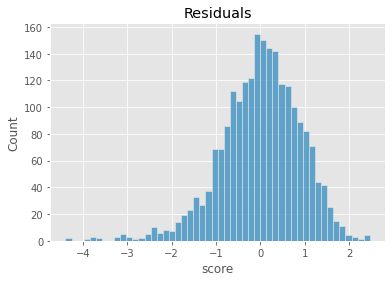

                                                                  0
model_name                      Linear Regression (normalize: True)
explained_variance r^2                                     0.094929
mean_absolute_error                                        0.695456
mean_squared_error                                         0.812112
root_mean_squared_error                                    0.901173
mean_absolute_percentage_error                             0.120191
model                              LinearRegression(normalize=True)


In [58]:
if continuous:
    # fitting a regression model
    m = LinearRegression()
    parameters = {
        'fit_intercept':[True,False], 
        'normalize':[True,False], 
        'copy_X':[True, False]
        }
    
    gs = GridSearchCV(m,parameters,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    model= gs.best_estimator_

    n = gs.best_params_['normalize']
    fit_model(model, f'Linear Regression (normalize: {n})', train_X, valid_X, train_y, valid_y)

### Decision Tree

{'max_depth': 9, 'min_impurity_decrease': 0.001, 'min_samples_split': 5}


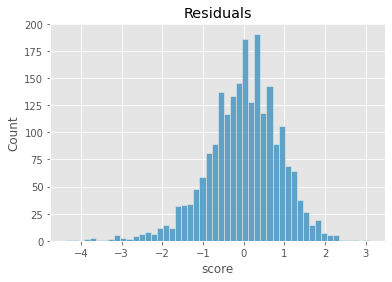

                                                                                0
model_name                                                          Decision_Tree
explained_variance r^2                                                   0.085198
mean_absolute_error                                                       0.69478
mean_squared_error                                                       0.820904
root_mean_squared_error                                                  0.906037
mean_absolute_percentage_error                                           0.120056
model                           DecisionTreeRegressor(max_depth=9, min_impurit...


In [59]:
if continuous:
    m = DecisionTreeRegressor()
    parameters = {
        'max_depth': range(3, 10),
        'min_samples_split': range(5, 10),
        'min_impurity_decrease': [.01, .001, .0001]
    }
else:
    m = DecisionTreeClassifier()
    parameters = {
        'max_depth': range(3, 10),
        'min_samples_split': range(5, 10),
        'min_impurity_decrease': [.01, .001, .0001]
    }

gs = GridSearchCV(m,parameters,cv=cv,n_jobs=n_jobs,scoring=scoring)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'Decision_Tree', train_X, valid_X, train_y, valid_y)

### Random Forest

{'max_depth': 7, 'n_estimators': 87}


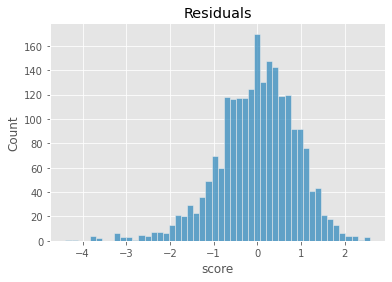

                                                                                0
model_name                                                          Random_Forest
explained_variance r^2                                                   0.089982
mean_absolute_error                                                      0.697421
mean_squared_error                                                       0.816604
root_mean_squared_error                                                  0.903661
mean_absolute_percentage_error                                           0.120491
model                           (DecisionTreeRegressor(max_depth=7, max_featur...


In [60]:
if continuous:
    m = RandomForestRegressor()
    parameters = {
        'max_depth': range(3, 10),
        'n_estimators': range(75, 100),
    }
else:
    m = RandomForestClassifier()
    parameters = {
        'max_depth': range(3, 10),
        'n_estimators': range(75, 100),
    }

gs = GridSearchCV(m,parameters,cv=cv,n_jobs=n_jobs,scoring=scoring)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'Random_Forest', train_X, valid_X, train_y, valid_y)

### AdaBoost

{'n_estimators': 78}


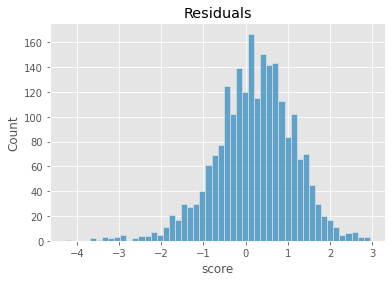

                                                                                0
model_name                                                              Ada_Boost
explained_variance r^2                                                    0.02102
mean_absolute_error                                                      0.754145
mean_squared_error                                                       0.921018
root_mean_squared_error                                                  0.959697
mean_absolute_percentage_error                                           0.125312
model                           (DecisionTreeRegressor(max_depth=8, max_featur...


In [62]:
if continuous:
    max_depth = 8
    m = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features="auto", max_depth=max_depth))
    parameters ={
        'n_estimators': range(75, 100),
        }
else:
    max_depth = 8
    m = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features="auto", max_depth=max_depth))
    parameters ={
        "base_estimator__criterion" : ["gini", "entropy"],
        "base_estimator__splitter" :   ["best", "random"],
        'n_estimators': range(75, 100),
        }

gs = GridSearchCV(m, param_grid=parameters)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'Ada_Boost', train_X, valid_X, train_y, valid_y)

### XGBoost (Simple)

{}


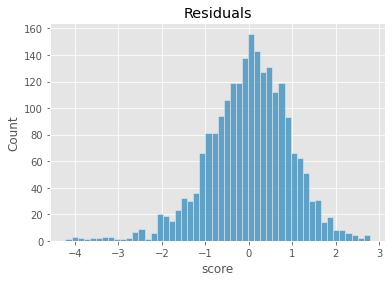

                                                                                0
model_name                                                      XG_Boost (Simple)
explained_variance r^2                                                  -0.011872
mean_absolute_error                                                       0.73263
mean_squared_error                                                       0.907917
root_mean_squared_error                                                  0.952847
mean_absolute_percentage_error                                           0.125925
model                           XGBRegressor(base_score=0.5, booster='gbtree',...


In [63]:
if continuous:
    m = XGBRegressor()
    parameters = {}
else:
    m = XGBClassifier()
    parameters = {}

gs = GridSearchCV(m, parameters, cv = cv, n_jobs = n_jobs, verbose=False)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'XG_Boost (Simple)', train_X, valid_X, train_y, valid_y)

### XGBoost (GridSearch)

This is a long running process. Won't run by default.

In [64]:
run_xg_boost_gs = False

if run_xg_boost_gs:
    if continuous:
        m = XGBRegressor()
        parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                    'objective':['reg:squarederror'],
                    'learning_rate': [.03, 0.05, .07], #so called `eta` value
                    'max_depth': [5, 6, 7],
                    'min_child_weight': [4],
                    'subsample': [0.7],
                    'colsample_bytree': [0.7],
                    'n_estimators': [500]}
    else:
        m = XGBClassifier()
        parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                'objective':['binary:logistic'],
                'learning_rate': [0.05], #so called `eta` value
                'max_depth': [6],
                'min_child_weight': [11],
                'subsample': [0.8],
                'colsample_bytree': [0.7],
                'n_estimators': [5], #number of trees, change it to 1000 for better results
                'missing':[-999],
                'seed': [1337]}

    gs = GridSearchCV(m, parameters, cv = cv, n_jobs = n_jobs, verbose=False)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    model= gs.best_estimator_

    fit_model(model, 'XG_Boost (GridSearch)', train_X, valid_X, train_y, valid_y)

### Gradient Boost

{'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 500}


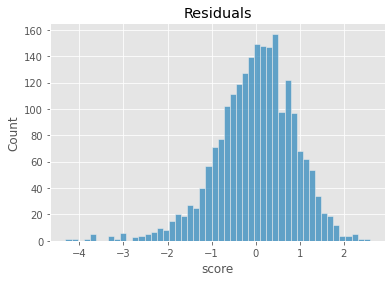

                                                                                0
model_name                                            Gradient_Boost (GridSearch)
explained_variance r^2                                                   0.106788
mean_absolute_error                                                      0.689022
mean_squared_error                                                       0.801515
root_mean_squared_error                                                  0.895274
mean_absolute_percentage_error                                           0.119176
model                           ([DecisionTreeRegressor(criterion='friedman_ms...


In [65]:
if continuous:
    m = GradientBoostingRegressor()
    parameters = {
                'n_estimators': [500, 1000],
                'learning_rate': [0.02, 0.05],
                'max_depth': [1, 2],
                'min_samples_leaf': [5, 10],
                'min_samples_split': [5, 10]}
else:
    m = GradientBoostingClassifier()
    parameters = {
                "loss":["deviance"],
                "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                "min_samples_split": np.linspace(0.1, 0.5, 12),
                "min_samples_leaf": np.linspace(0.1, 0.5, 12),
                "max_depth":[3,5,8],
                "max_features":["log2","sqrt"],
                "criterion": ["friedman_mse",  "mae"],
                "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
                "n_estimators":[10]}

gs = GridSearchCV(m, parameters, cv = cv, n_jobs = n_jobs, verbose=False)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'Gradient_Boost (GridSearch)', train_X, valid_X, train_y, valid_y)

### Support Vector (Simple)

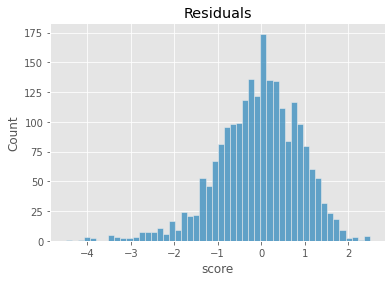

                                                      0
model_name                      Support_Vector (Simple)
explained_variance r^2                         0.003358
mean_absolute_error                            0.729724
mean_squared_error                             0.898739
root_mean_squared_error                        0.948019
mean_absolute_percentage_error                 0.127398
model                                             SVR()


In [66]:
if continuous:
    model = SVR()
    
else:
    model = SVC()

fit_model(model, 'Support_Vector (Simple)', train_X, valid_X, train_y, valid_y)

### Support Vector (GridSearch)

- ref [toward data science](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2)
- ref [stackoverflow](https://stackoverflow.com/questions/57495123/optimizing-svr-parameters-using-gridsearchcv)

This is a long running process. Won't run by default.

In [67]:
run_sv_gridsearch = False

if run_sv_gridsearch:
    if continuous:
        m = SVR()
        parameters = {
            'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
            'C' : [1, 5, 10],
            'degree' : [3, 8],
            'coef0' : [0.01, 10, 0.5],
            'gamma' : ('auto', 'scale')}
    else:
        m = SVC()
        parameters = {}

    gs = GridSearchCV(m, parameters, cv = cv, n_jobs = n_jobs, verbose=False)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    model= gs.best_estimator_

    fit_model(model, 'Support_Vector (GridSearch)', train_X, valid_X, train_y, valid_y)

### knn

{'n_neighbors': 23, 'weights': 'uniform'}


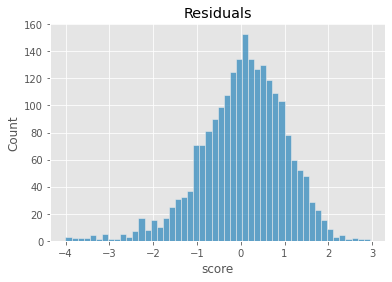

                                                                  0
model_name                                        kNearest_Neighbor
explained_variance r^2                                    -0.027674
mean_absolute_error                                         0.74783
mean_squared_error                                         0.925042
root_mean_squared_error                                    0.961791
mean_absolute_percentage_error                             0.127733
model                           KNeighborsRegressor(n_neighbors=23)


In [68]:
if continuous:
    m = KNeighborsRegressor()
    parameters = {
                'n_neighbors': range(15, 30),
                'weights': ['uniform','distance']}
else:
    m = KNeighborsClassifier()
    parameters = {
                'n_neighbors': range(15, 30),
                'weights': ['uniform','distance']}

gs = GridSearchCV(m, parameters, cv=cv, n_jobs=n_jobs, scoring=scoring)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'kNearest_Neighbor', train_X, valid_X, train_y, valid_y)

### Neural Net

C:\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-6.90821653e-04 -6.80615461e-04 -3.54740845e-03 -2.46732018e+01
             nan -2.80931006e+01 -6.90822238e-04 -7.02419056e-04
 -7.01489752e-03 -6.90822221e-04 -8.15226166e+50 -2.66647942e+01]
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 2, 'max_iter': 200, 'solver': 'sgd'}


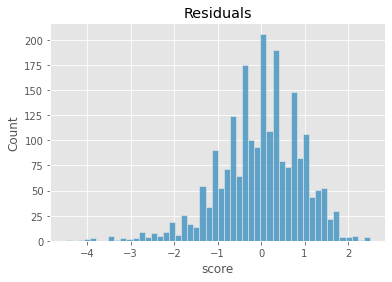

                                                                                0
model_name                                                    Neural Net (Simple)
explained_variance r^2                                                        0.0
mean_absolute_error                                                      0.732088
mean_squared_error                                                       0.897281
root_mean_squared_error                                                  0.947249
mean_absolute_percentage_error                                           0.126624
model                           MLPRegressor(activation='logistic', hidden_lay...


In [69]:
if continuous:
    m = MLPRegressor()
    parameters = {
                'hidden_layer_sizes': [2],
                'activation': ['logistic', 'identity', 'tanh', 'relu'], #logistic' (sigmoid), 'identity', 'tanh', 'relu'
                'solver': ['lbfgs', 'sgd', 'adam'], # 'lbfgs', 'sgd', 'adam'
                'max_iter': [200], #default=200
                'alpha': [0.0001]} # default=0.0001
else:
    m = MLPClassifier()
    parameters = {
                'hidden_layer_sizes': [2],
                'activation': ['logistic', 'identity', 'tanh', 'relu'], #logistic' (sigmoid), 'identity', 'tanh', 'relu'
                'solver': ['lbfgs', 'sgd', 'adam'], # 'lbfgs', 'sgd', 'adam'
                'max_iter': [200], #default=200
                'alpha': [0.0001]} # default=0.0001

gs = GridSearchCV(m, parameters, cv = cv, n_jobs = n_jobs, verbose=False)
gs.fit(train_X,train_y)
print(gs.best_params_)
model= gs.best_estimator_

fit_model(model, 'Neural Net (Simple)', train_X, valid_X, train_y, valid_y)

C:\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-6.90821196e-04 -6.26184977e-04 -3.01599911e-03 -6.90818490e-04
 -6.86322909e-04 -1.34533255e-03 -6.90829340e-04 -7.40614200e-04
 -9.34311939e-04 -6.90821421e-04 -6.88591466e-04 -1.08561388e-03
 -6.90823023e-04 -6.89399981e-04 -1.06186330e-03 -6.90821603e-04
 -7.27169802e-04 -8.46211689e-04 -6.90822454e-04 -6.54235229e-04
 -2.98298543e-01 -6.90822309e-04 -7.23081688e-04 -1.14164912e-03
 -6.90821740e-04 -6.83510370e-04 -9.28758130e-04 -6.90822217e-04
 -7.25481441e-04 -9.78975272e-04 -6.90822077e-04 -7.63416720e-04
 -9.94368888e-04 -6.90821996e-04 -6.47248458e-04 -6.91506533e-04
 -6.90822208e-04 -7.03658083e-04 -1.16832425e-02 -6.90822157e-04
 -6.73276798e-04 -1.00630470e-03 -6.90822232e-04 -6.56789160e-04
 -7.83209346e-04 -6.90822212e-04 -6.17496850e-04 -8.31565886e-04
 -6.90822266e-04 -7.09293468e-04 -7.44111758e-04 -6.90822196e-04
 -7.32680473e-04 -

{'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': 4, 'max_iter': 200, 'solver': 'sgd'}


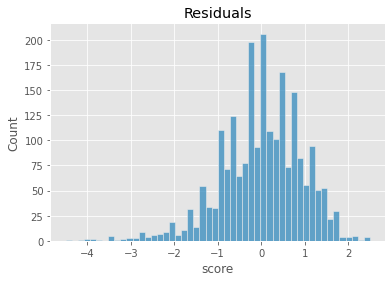

                                                                                0
model_name                                                Neural Net (GridSearch)
explained_variance r^2                                                        0.0
mean_absolute_error                                                      0.731888
mean_squared_error                                                       0.897305
root_mean_squared_error                                                  0.947262
mean_absolute_percentage_error                                           0.126634
model                           MLPRegressor(activation='tanh', alpha=1e-05, h...


In [71]:
run_nn_gridsearch = True

if run_nn_gridsearch:
    if continuous:
        m = MLPRegressor()
        parameters = {
                    'hidden_layer_sizes': [2, 3, 4],
                    'activation': ['logistic', 'identity', 'tanh', 'relu'],
                    'solver': ['lbfgs', 'sgd', 'adam'],
                    'max_iter': [200, 1000],
                    'alpha': [0.001, 0.0001, 0.00001]}
    else:
        m = MLPClassifier()
        parameters = {
                    'hidden_layer_sizes': [2, 3, 4],
                    'activation': ['logistic', 'identity', 'tanh', 'relu'],
                    'solver': ['lbfgs', 'sgd', 'adam'],
                    'max_iter': [100, 200, 1000],
                    'alpha': [0.001, 0.0001, 0.00001]}

    gs = GridSearchCV(m, parameters, cv = cv, n_jobs = n_jobs, verbose=False)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    model= gs.best_estimator_

    fit_model(model, 'Neural Net (GridSearch)', train_X, valid_X, train_y, valid_y)

# Select Model


In [72]:
df_models = pd.DataFrame(all_models).T
df_models.sort_values(by='mean_absolute_percentage_error')


,model_name,explained_variance r^2,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,model
5,Gradient_Boost (GridSearch),0.106788,0.689022,0.801515,0.895274,0.119176,([DecisionTreeRegressor(criterion='friedman_ms...
1,Decision_Tree,0.085198,0.69478,0.820904,0.906037,0.120056,"DecisionTreeRegressor(max_depth=9, min_impurit..."
0,Linear Regression (normalize: True),0.094929,0.695456,0.812112,0.901173,0.120191,LinearRegression(normalize=True)
2,Random_Forest,0.089982,0.697421,0.816604,0.903661,0.120491,"(DecisionTreeRegressor(max_depth=7, max_featur..."
3,Ada_Boost,0.02102,0.754145,0.921018,0.959697,0.125312,"(DecisionTreeRegressor(max_depth=8, max_featur..."
4,XG_Boost (Simple),-0.011872,0.73263,0.907917,0.952847,0.125925,"XGBRegressor(base_score=0.5, booster='gbtree',..."
8,Neural Net (Simple),0.0,0.732088,0.897281,0.947249,0.126624,"MLPRegressor(activation='logistic', hidden_lay..."
9,Neural Net (GridSearch),0.0,0.731888,0.897305,0.947262,0.126634,"MLPRegressor(activation='tanh', alpha=1e-05, h..."
6,Support_Vector (Simple),0.003358,0.729724,0.898739,0.948019,0.127398,SVR()
7,kNearest_Neighbor,-0.027674,0.74783,0.925042,0.961791,0.127733,KNeighborsRegressor(n_neighbors=23)


In [75]:
selected_model = df_models[df_models['model_name'] == 'Gradient_Boost (GridSearch)']['model'].values[0] # select gradient_boost based on lowest mape

# Tune Model

### Make Predictions on Validation Data

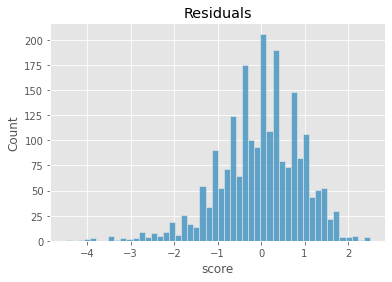

                                                                                0
model_name                                                         Selected_Model
explained_variance r^2                                                        0.0
mean_absolute_error                                                       0.73216
mean_squared_error                                                       0.897274
root_mean_squared_error                                                  0.947246
mean_absolute_percentage_error                                            0.12662
model                           MLPRegressor(activation='tanh', alpha=1e-05, h...


In [76]:
result = fit_model(model, 'Selected_Model', train_X, valid_X, train_y, valid_y)


# Make a totally new prediction

In [77]:
X.head(1).T

,0
budget,19000000.0
genre_Adventure,0.0
genre_Animation,0.0
genre_Biography,0.0
genre_Comedy,0.0
genre_Crime,0.0
genre_Drama,1.0
genre_Family,0.0
genre_Fantasy,0.0
genre_Horror,0.0


In [78]:
newObs = pd.DataFrame([{
    'budget': 30_000_000.0,
    'genre_Adventure': 1.0,
    'genre_Animation': 0.0,
    'genre_Biography': 0.0,
    'genre_Comedy': 0.0,
    'genre_Crime': 0.0,
    'genre_Drama': 0.0,
    'genre_Family': 0.0,
    'genre_Fantasy': 0.0,
    'genre_Horror': 0.0,
    'genre_Mystery': 0.0,
    'genre_Romance': 0.0,
    'genre_Sci-Fi': 0.0,
    'genre_Thriller': 0.0,
    'genre_Western': 0.0,
    'release_day_of_week_Monday': 0.0,
    'release_day_of_week_Saturday': 0.0,
    'release_day_of_week_Sunday': 0.0,
    'release_day_of_week_Thursday': 0.0,
    'release_day_of_week_Tuesday': 0.0,
    'release_day_of_week_Wednesday': 1.0,
}])

if normalize:
    newObs_scaled = scaler.transform(newObs)
    newObs_scaled = pd.DataFrame(newObs_scaled, columns=newObs.columns)
    newObs = newObs_scaled

newObs_thin = newObs.loc[:, ~(newObs == 0).any()]

# predict it's score
print(f'What score do we expect from a new observation with the following features?\n{newObs_thin.T}\n')

outcome = selected_model.predict(newObs[X.columns])[0]

if normalize:
    outcome = outcome * 10

print(f'{outcome_var_name}: {outcome:.1f}')


What score do we expect from a new observation with the following features?
                                        0
budget                         30000000.0
genre_Adventure                       1.0
release_day_of_week_Wednesday         1.0

score: 6.4
